In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm

import seaborn as sns
import pandas as pd

In [2]:
plt.style.use("seaborn-whitegrid")

In this game $L^2$ individual "*players*" placed in a two-dimensional spatial array.

Every individual can play one of two tactics: cooperate($\mathcal{C}$) or defect($\mathcal{D}$). At the beginning of the "game", each player has the probability of being assigned $\mathcal{C}$ with probability $p_c$ and tactics $\mathcal{D}$ otherwise.

In each round individuals "*play the game*" with 8 its neighbors and the *average cooperator*. Tables of payoffs shown below

Table: Payoffs for games with neighbors.

| payoffs | $\mathcal{D}$ | $\mathcal{C}$ |
| --------- |:-------------:|----:|
| $\mathcal{D}$ | 0 | 0 |
| $\mathcal{C}$ | $b$ | 1 |

Table: Payoffs for games with *average cooperator*

| payoffs | $\mathcal{D}$ | $\mathcal{C}$ |
| --------- |:-------------:|----:|
| $\mathcal{D}$ | 0 | 0 |
| $\mathcal{C}$ | $b f_c$ | $f_c$ |

After playing all games the site occupied either by its original owner or by one of the neighbors who scores the highest total payoff in that round.

## Transition values(local)

The game is defined by the payoff $b$ and different behaviour is expected at different $b$

To find the values of $b$ at which transition occurs we have to understand at which values the total outcome of agent may change.


<img src="./figures/neighbourhoods.png" alt="drawing" width="300"/>

By looking at picture above we can come up with this formuls for $b$
$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c+1}$$
for left hand side configurations

$$b=\frac{n_{c\;shared}+n_c+f_c}{n_{c\;shared}+n_d+f_c}$$
for right hand side configurations

Where

$n_{c\;shared}$ - number of cooperators($\mathcal{C}$) from red region

$n_c$ - number of cooperators near cooperator(purple region)

$n_d$ - number of cooperators near defector(yellow region)

$f_c$ - density of cooperators

Both these formulas can be generalized as
$$b=\frac{m+f_c}{n+f_c}$$

In [3]:
def trans_val(f_c, m, n):
    return (m+f_c)/(n+f_c)

def trans_novak_may(m, n):
    return m/n

In [4]:
f_cs = np.linspace(0, 1, 20)

In [6]:
all_transitions = []
old_transitions = []

for m in range(0, 9):
    for n in range(0, 9):
        if n == 0:
            all_transitions.append(trans_val(np.linspace(0.00000001, 1, 20), m, n))
        else:
            all_transitions.append(trans_val(f_cs, m, n))
            old_transitions.append(m/n)

In [7]:
transitions = []
for i, tr in enumerate(all_transitions[:-1]):
    if not (np.square(np.array(all_transitions[i+1:]) - tr).sum(-1) < 0.0000001).any():
        transitions.append(tr)
transitions.append(all_transitions[-1])

transitions_old = []
for i, tr in enumerate(old_transitions[:-1]):
    if not (np.square(np.array(old_transitions[i+1:]) - tr) < 0.0000001).any():
        transitions_old.append(tr)
transitions_old.append(old_transitions[-1])

Values of transitions for the game with itself were taken from the article "The spatial dilemmas of evolution" by A. Novak and M. May, 1993

# N-M distribution

In [8]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'))

In [9]:
bs = [1.5       , 1.50689655, 1.5137931 , 1.52068966, 1.52758621,
      1.53448276, 1.54137931, 1.54827586, 1.55517241, 1.56206897,
      1.56896552, 1.57586207, 1.58275862, 1.58965517, 1.59655172,
      1.60344828, 1.61034483, 1.61724138, 1.62413793, 1.63103448,
      1.63793103, 1.64482759, 1.65172414, 1.65862069]
nm = np.load("data/200x200run/nmdistribution.npy").reshape((-1, 9, 9))
cluster_sizes = np.load("data/200x200run/clustersizedist.npy")
persistence = np.load("data/200x200run/persistence.npy")
density = np.load("data/200x200run/density.npy")

<IPython.core.display.Javascript object>


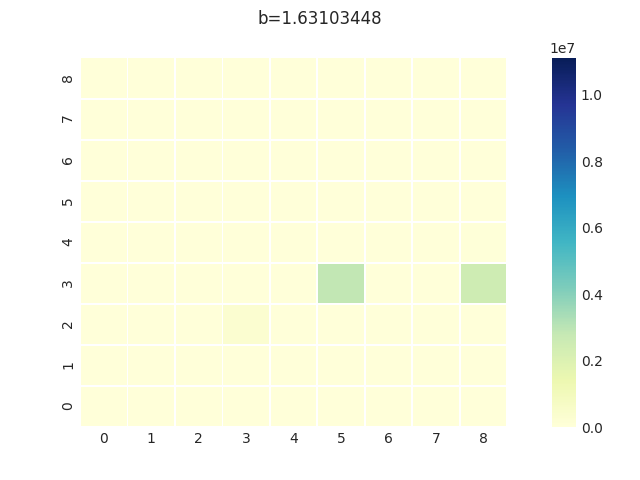

In [11]:
grid_kws = {"width_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(1, 2, gridspec_kw=grid_kws)

mx = nm.max()
sns.heatmap(nm[0][::-1], linewidth=0.5, yticklabels=range(8, -1, -1), cmap="YlGnBu",ax=ax,
                     cbar_ax=cbar_ax,
                     vmax=mx,
                     cbar_kws={"orientation": "vertical"})
def animate(i):
    plt.suptitle(f"b={bs[i]}")
    p = sns.heatmap(nm[i][::-1], linewidth=0.5, yticklabels=range(8, -1, -1), cmap="YlGnBu",ax=ax,
                     cbar_ax=cbar_ax,
                    vmax=mx,
                     cbar_kws={"orientation": "vertical"})
    
ani = animation.FuncAnimation(f, animate, frames=24, repeat=True)
ani.save("nmdistribution.mp4", writer=writer, dpi=300)

# Cluster sizes

In [12]:
i = 0
max_s = 250
clusts = {
    "class": ['D']*(max_s-2) + ['C']*(max_s-2),
    "size": list(range(2, max_s)) + list(range(2, max_s)),
    "value": cluster_sizes[0, i, 2:max_s].tolist() + cluster_sizes[1, i, 2:max_s].tolist()
}
data = pd.DataFrame(clusts, columns=["class", "value", "size"])

<IPython.core.display.Javascript object>


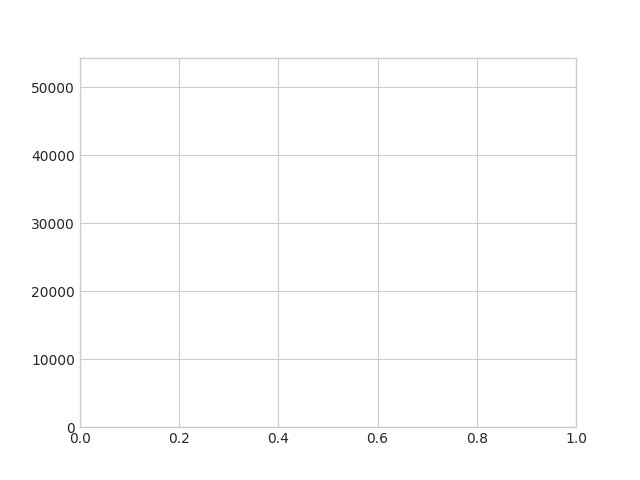

<IPython.core.display.Javascript object>


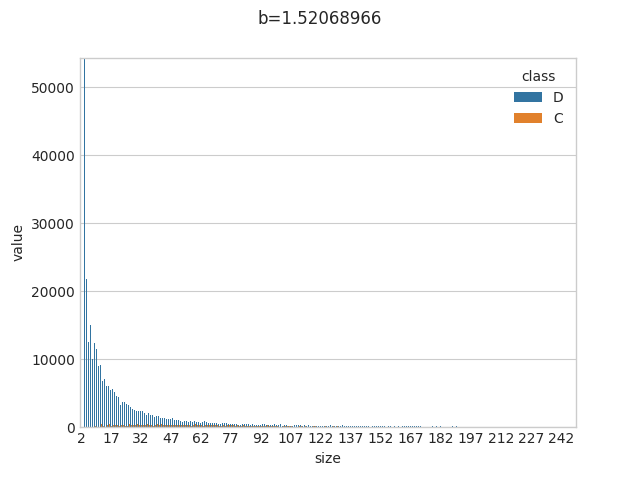

In [13]:
plt.ylim(0, cluster_sizes[1, :, 2:250].max())
grid_kws = {"width_ratios": (1,)}
f, ax = plt.subplots(1, 1, gridspec_kw=grid_kws)

mx = nm.max()
p = sns.barplot(x="size", y="value", hue="class", data=data,ax=ax)
for ind, label in enumerate(p.get_xticklabels()):
    if ind % 10 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)


def animate(i):
    clusts["value"] = cluster_sizes[0, i, 2:max_s].tolist() + cluster_sizes[1, i, 2:max_s].tolist()
    data = pd.DataFrame(clusts, columns=["class", "value", "size"])
    ax.clear()
    plt.ylim(0, cluster_sizes[1, :, 2:max_s].max())
    plt.suptitle(f"b={bs[i]}")
    p = sns.barplot(x="size", y="value", hue="class", data=data,ax=ax)
    for ind, label in enumerate(p.get_xticklabels()):
        if ind % 15 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)
    
ani = animation.FuncAnimation(f, animate, frames=24, repeat=True)
ani.save("clus.mp4", writer=writer, dpi=300)

# Square Grid

In [14]:
bs = [0.9       , 0.91864407, 0.93728814, 0.9559322 , 0.97457627,
     0.99322034, 1.01186441, 1.03050847, 1.04915254, 1.06779661,
     1.08644068, 1.10508475, 1.12372881, 1.14237288, 1.16101695,
     1.17966102, 1.19830508, 1.21694915, 1.23559322, 1.25423729,
     1.27288136, 1.29152542, 1.31016949, 1.32881356, 1.34745763,
     1.36610169, 1.38474576, 1.40338983, 1.4220339 , 1.44067797,
     1.45932203, 1.4779661 , 1.49661017, 1.51525424, 1.53389831,
     1.55254237, 1.57118644, 1.58983051, 1.60847458, 1.62711864,
     1.64576271, 1.66440678, 1.68305085, 1.70169492, 1.72033898,
     1.73898305, 1.75762712, 1.77627119, 1.79491525, 1.81355932,
     1.83220339, 1.85084746, 1.86949153, 1.88813559, 1.90677966,
     1.92542373, 1.9440678 , 1.96271186, 1.98135593, 2.        ]
persistence_m = np.load("data/200MeanGame/persistence.npy")
density_m = np.load("data/200MeanGame/density.npy")

persistence_n = np.load("data/200NovakMayGame/persistence.npy")
density_n = np.load("data/200NovakMayGame/density.npy")

<IPython.core.display.Javascript object>


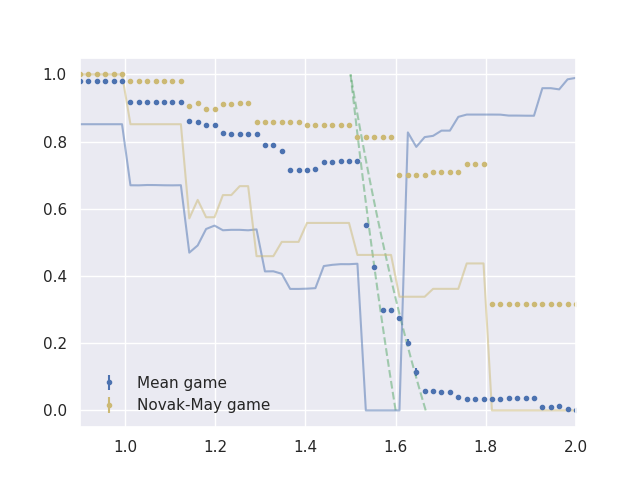

In [18]:
sns.set()
plt.xlim(.9, 2)
plt.errorbar(bs, density_m[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_m[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt=".b", label="Mean game")
plt.errorbar(bs, density_n[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_n[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt=".y", label="Novak-May game")
plt.plot(trans_val(f_cs, 8, 5), f_cs, "g--", alpha=.5)
plt.plot(trans_val(f_cs, 5, 3), f_cs, "g--", alpha=.5)

plt.plot(bs, persistence_m.mean(axis=-1), "b-", alpha=.5)
plt.plot(bs, persistence_n.mean(axis=-1), "y-", alpha=.5)

plt.legend()

# Triangular game

In [19]:
persistence_m = np.load("data/MeanTriangle/persistence.npy")
density_m = np.load("data/MeanTriangle/density.npy")

persistence_n = np.load("data/NovakMayTriangle/persistence.npy")
density_n = np.load("data/NovakMayTriangle/density.npy")

<IPython.core.display.Javascript object>


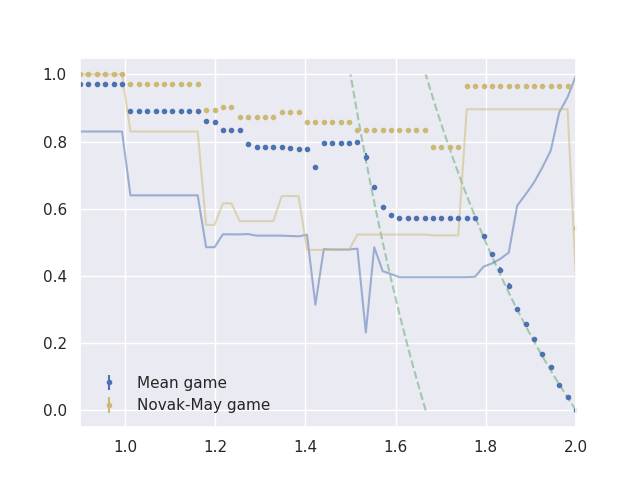

In [24]:
sns.set()
plt.xlim(.9, 2)
plt.errorbar(bs, density_m[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_m[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt=".b", label="Mean game")
plt.errorbar(bs, density_n[:, :, 10000:].mean(axis=-1).mean(axis=-1), yerr=density_n[:, :, 10000:].mean(axis=-1).std(axis=-1), fmt=".y", label="Novak-May game")
plt.plot(trans_val(f_cs, 5, 3), f_cs, "g--", alpha=.5)
plt.plot(trans_val(f_cs, 4, 2), f_cs, "g--", alpha=.5)

plt.plot(bs, persistence_m.mean(axis=-1), "b-", alpha=.5)
plt.plot(bs, persistence_n.mean(axis=-1), "y-", alpha=.5)

plt.legend()